# Facial Similarity with Siamese network and LFW dataset

In [35]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from torch.utils.data import Dataset
from torchvision import transforms

### DataLoader

In [36]:
class LFWDataset(Dataset):
    def __init__(self, pairs_file, img_folder, transform=None):
        self.pairs_file = pairs_file
        self.img_folder = img_folder
        self.transform = transform
        self.image_pairs, self.labels = self._load_pairs()


    def _load_pairs(self):
        with open(self.pairs_file, 'r') as f:
            pairs = f.readlines()[1:]
        image_pairs = []
        labels = []

        for pair in pairs:
            pair = pair.strip().split()
            if len(pair) == 3:
                person = pair[0]
                img_1 = os.path.join(self.img_folder, person, f"{person}_{int(pair[1]):04d}.jpg")
                img_2 = os.path.join(self.img_folder, person, f"{person}_{int(pair[2]):04d}.jpg")
                label = 1
            else:
                person_1 = pair[0]
                person_2 = pair[2]
                img_1 = os.path.join(self.img_folder, person_1, f"{person_1}_{int(pair[1]):04d}.jpg")
                img_2 = os.path.join(self.img_folder, person_2, f"{person_2}_{int(pair[3]):04d}.jpg")
                label = 0

            image_pairs.append((img_1, img_2))
            labels.append(label)

        return image_pairs, labels
    

    def __getitem__(self, index):
        path_img_1, path_img_2 = self.image_pairs[index]
        label = self.labels[index]

        img_1 = Image.open(path_img_1).convert("RGB")
        img_2 = Image.open(path_img_2).convert("RGB")

        if self.transform:
            img_1 = self.transform(img_1)
            img_2 = self.transform(img_2)

        return img_1, img_2, torch.tensor([label], dtype=torch.float32)
    

    def __len__(self):
        return len(self.image_pairs)

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

lfw_dataset = LFWDataset(pairs_file='/home/mehran/Documents/Datasets/pairsDevTrain.txt', img_folder='/home/mehran/Documents/Datasets/lfw-deepfunneled', transform=transform)
train_size = int(0.8 * len(lfw_dataset))
val_size = len(lfw_dataset) - train_size
train_dataset, val_dataset = random_split(lfw_dataset, [train_size, val_size])


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

### Siamese Network Architecture

In [37]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten()
        )

        self.fc = nn.Sequential(
            nn.Linear(128 * 32 * 32, 512),
            nn.ReLU(),
            nn.Linear(512, 128)
        )

    def forward_once(self, x):
        x = self.cnn(x)
        x = self.fc(x)
        return x
    
    def forward(self, input_1, input_2):
        output_1 = self.forward_once(input_1)
        output_2 = self.forward_once(input_2)
        return output_1, output_2
    

model = SiameseNetwork()

### Loss Function(Contrastive Loss)

In [38]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    
    def forward(self, output_1, output_2, label):
        euclidean_distance = nn.functional.pairwise_distance(output_1, output_2)
        loss_contrastive = torch.mean(
        (1 - label) * torch.pow(euclidean_distance, 2) +
        label * torch.pow(torch.clamp(
            self.margin - euclidean_distance, min=0.0), 2)
        )
        return loss_contrastive
    

criterion = ContrastiveLoss()

### Checkpoint

In [44]:
file_path = os.path.expanduser('~/VScode/current/Facial_Similarity')

def save_checkpoint(state, filename=None):
    if filename is None:
        filename = os.path.join(file_path, 'best_model.pth')
    
    torch.save(state, filename)

def load_checkpoint(model, optimizer, filename=None):
    if filename is None:
        filename = os.path.join(file_path, 'best_model.pth')
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        loss = checkpoint['loss']
        print(f"Checkpoint loaded: Epoch {epoch}, Loss {loss:.4f}")
        return epoch, loss


### Training Loop

In [45]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 10

def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=EPOCHS):
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0

        train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", leave=False)

        for img_1, img_2, label in train_loop:
            # img_1, img_2, label = img_1.cuda(), img_2.cuda(), label.cuda()
            optimizer.zero_grad()
            output_1, output_2 = model(img_1, img_2)
            train_loss = criterion(output_1, output_2, label)
            train_loss.backward()
            optimizer.step()
            total_train_loss += train_loss.item()

            train_loop.set_postfix(loss=train_loss.item())

        avg_train_loss = total_train_loss / len(train_loader)

        val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", leave=False)
        model.eval()
        total_val_loss = 0
        
        with torch.no_grad():
            for img_1, img_2, label in val_loop:
                output_1, output_2 = model(img_1, img_2)
                val_loss = criterion(output_1, output_2, label)
                total_val_loss += val_loss.item()

                val_loop.set_postfix(loss=val_loss.item())

        avg_val_loss = total_val_loss / len(val_loader)

        print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')


        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            print(f"Saving model checkpoint at epoch {epoch+1}, Validation Loss: {best_val_loss:.4f}")
            save_checkpoint({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_val_loss,
            })

    
train(model, train_loader, val_loader, criterion, optimizer)

Epoch [1/10] - Train Loss: 0.2710, Val Loss: 0.2692
Saving model checkpoint at epoch 1, Validation Loss: 0.2692


Epoch [2/10] - Train Loss: 0.2681, Val Loss: 0.2703


Epoch [3/10] - Train Loss: 0.2643, Val Loss: 0.2737


Epoch [4/10] - Train Loss: 0.2613, Val Loss: 0.2844


Epoch [5/10] - Train Loss: 0.2618, Val Loss: 0.2623
Saving model checkpoint at epoch 5, Validation Loss: 0.2623


Epoch [6/10] - Train Loss: 0.2593, Val Loss: 0.2635


Epoch [7/10] - Train Loss: 0.2566, Val Loss: 0.2640


Epoch [8/10] - Train Loss: 0.2632, Val Loss: 0.2670


Epoch [9/10] - Train Loss: 0.2583, Val Loss: 0.2654


Epoch [10/10] - Train Loss: 0.2584, Val Loss: 0.2634


### Test the Model on Two Images

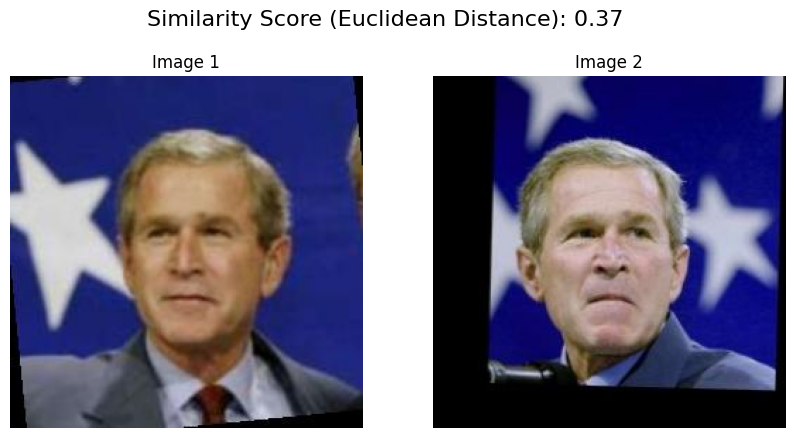

In [46]:
def show_result(model, img1_path, img2_path, transform):

    img1 = Image.open(img1_path).convert("RGB")
    img2 = Image.open(img2_path).convert("RGB")

    img1 = transform(img1).unsqueeze(0)
    img2 = transform(img2).unsqueeze(0)

    model.eval()
    with torch.no_grad():
        output1, output2 = model(img1, img2)

    euclidean_distance = nn.functional.pairwise_distance(output1, output2).item()

    img1 = np.array(Image.open(img1_path))
    img2 = np.array(Image.open(img2_path))

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img1)
    ax[0].axis('off')
    ax[0].set_title('Image 1')

    ax[1].imshow(img2)
    ax[1].axis('off')
    ax[1].set_title('Image 2')

    plt.suptitle(f'Similarity Score (Euclidean Distance): {euclidean_distance:.2f}', fontsize=16)
    plt.show()

path_img_1 = '/home/mehran/Documents/Datasets/lfw-deepfunneled/George_W_Bush/George_W_Bush_0001.jpg'
path_img_2 = '/home/mehran/Documents/Datasets/lfw-deepfunneled/George_W_Bush/George_W_Bush_0002.jpg'

show_result(model, path_img_1, path_img_2, transform)
